## Here I reweigh a fastdate chronogram distribution that was generated with a high variance (100 times larger than last time) according to the following command:
speed-dating/src/fastdate --out_form ultrametric -out_form ultrametric --method_relative --tree_file CanonicalRootBLOK_root_No0.txt --out_file canonicalRoot_Var500.tree --bd_mu 2 --bd_lambda 3 --bd_rho 0.01 --show_tree --grid 1000 --rate_mean 5 --rate_variance 500 --sample 10000

In [17]:
import sys
from ete3 import Tree, TreeStyle, NodeStyle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# Creates a tree
file="CanonicalRoot.txt"

try:
    f=open(file, 'r')
except IOError:
    print ("Unknown file: "+file)
    sys.exit()

line = ""
for l in f:
    line += l.strip()
    
f.close()

t = Tree( line )

Now we find the link between numbers and underlying leaf names.

In [2]:
def getNameToLeavesLink( t ):
    node2leaves = t.get_cached_content()
    nodeId2LeafList = dict()
    leafList2NodeId = dict()
    for k in node2leaves.keys():
        if len(node2leaves[k]) == 1: #leaf node
            pass
        else:
            nodelist = list()
            for n in node2leaves[k]:
                nodelist.append( n.name )
            nodelist.sort()
            nodeId2LeafList[k.support] = nodelist
            leafList2NodeId[tuple(nodelist)] = int(k.support) # Need to transform the mutable list into an immutable tuple
    return nodeId2LeafList, leafList2NodeId

nodeId2LeafListRef, leafList2NodeIdRef = getNameToLeavesLink( t )
print ("Number of internal leaves = " + str(len(nodeId2LeafListRef)) )



Number of internal leaves = 167


Function to renumber nodes as in a reference tree:

In [3]:
def renumberNodes( treeToAnnotate, leafList2NodeId ):
    #print treeToAnnotate.get_ascii(attributes=[ "name"], show_internal=False)
    node2leaves = treeToAnnotate.get_cached_content()
    for k in node2leaves.keys():
        if len(node2leaves[k]) == 1: #leaf node
            pass
        else:
            nodelist = list()
            for n in node2leaves[k]:
                nodelist.append( n.name )
            nodelist.sort()
            k.support = leafList2NodeId[tuple(nodelist)]



Getting node ages in a chronogram:

In [5]:

def getNodeHeights( t ):
    node2Height = dict()
    id2Height = dict()
    for node in t.traverse("postorder"):
        if node not in node2Height:
            node2Height[node] = 0.0
            id2Height[node.name] = 0.0
        if node.up:
            node2Height[node.up] = node2Height[node] + node.dist
            id2Height[str(node.up.support)] = node2Height[node] + node.dist
      # print node.name + " : " + str(node2Height[node])
    return node2Height,id2Height



Reading the constraints based on transfers detected using ALEml_undated: 

In [7]:
fileC = "CanonicalRoot_constraints.txt" # in which the first one is older than the second one
try:
    f=open(fileC, 'r')
except IOError:
    print ("Unknown file: "+fileC)
    sys.exit()

constraints = list()
for l in f:
    constraints.append( l.split() )
    
f.close()

print("Number of constraints: "+str(len(constraints)))

Number of constraints: 11978


Function to count the number of constraints met by a chronogram:

In [8]:
def checkConstraints(id2Height, constraints):
    numberOfMetConstraints = 0
    for c in constraints:
        try:
            if (id2Height[str(float(c[0]))] > id2Height[str(float(c[1]))]):
                numberOfMetConstraints = numberOfMetConstraints + 1
        except KeyError:
            print ("Constraint involving nodes " + str(float(c[0])) + " and " + str(float(c[1])) + " cannot be checked.")
    return numberOfMetConstraints



Now we score all trees from the distribution generated by fastdate:

In [10]:
fileT = "canonicalRoot_Var500.tree.sampled" 
try:
    f=open(fileT, 'r')
except IOError:
    print ("Unknown file: " + fileT)
    sys.exit()

allTrees = list()
for l in f:
    allTrees.append( Tree( l.strip() ) )

print ("Number of trees read: " + str(len(allTrees)))

def renumberAllTrees( allTrees, leafList2NodeIdRef ):
    for t in allTrees:
        renumberNodes( t, leafList2NodeIdRef )
     #   pbar.increment()

renumberAllTrees ( allTrees, leafList2NodeIdRef )
        
def scoreAllTrees(allTrees, constraints):
    scores = list()
    for t in allTrees:
        node2Height,id2Height = getNodeHeights( t )
        scores.append(checkConstraints(id2Height, constraints))
    return scores


scores = scoreAllTrees ( allTrees, constraints )



Number of trees read: 10000


Let's look at some statistics and save the scores we have computed:

In [12]:
df = pd.DataFrame( scores, columns=['scores'] )
df.to_csv("transferBasedScoresCanonicalRoot_Var500.csv")
print(df.describe())

             scores
count  10000.000000
mean    6381.817500
std       82.187177
min     6075.000000
25%     6326.000000
50%     6382.000000
75%     6437.000000
max     6694.000000


Let's reopen the scores:

In [13]:
df = pd.read_csv("transferBasedScoresCanonicalTree.csv")
scores = df['scores']

Let's look at the least supported and most supported trees. First, the least supported tree:

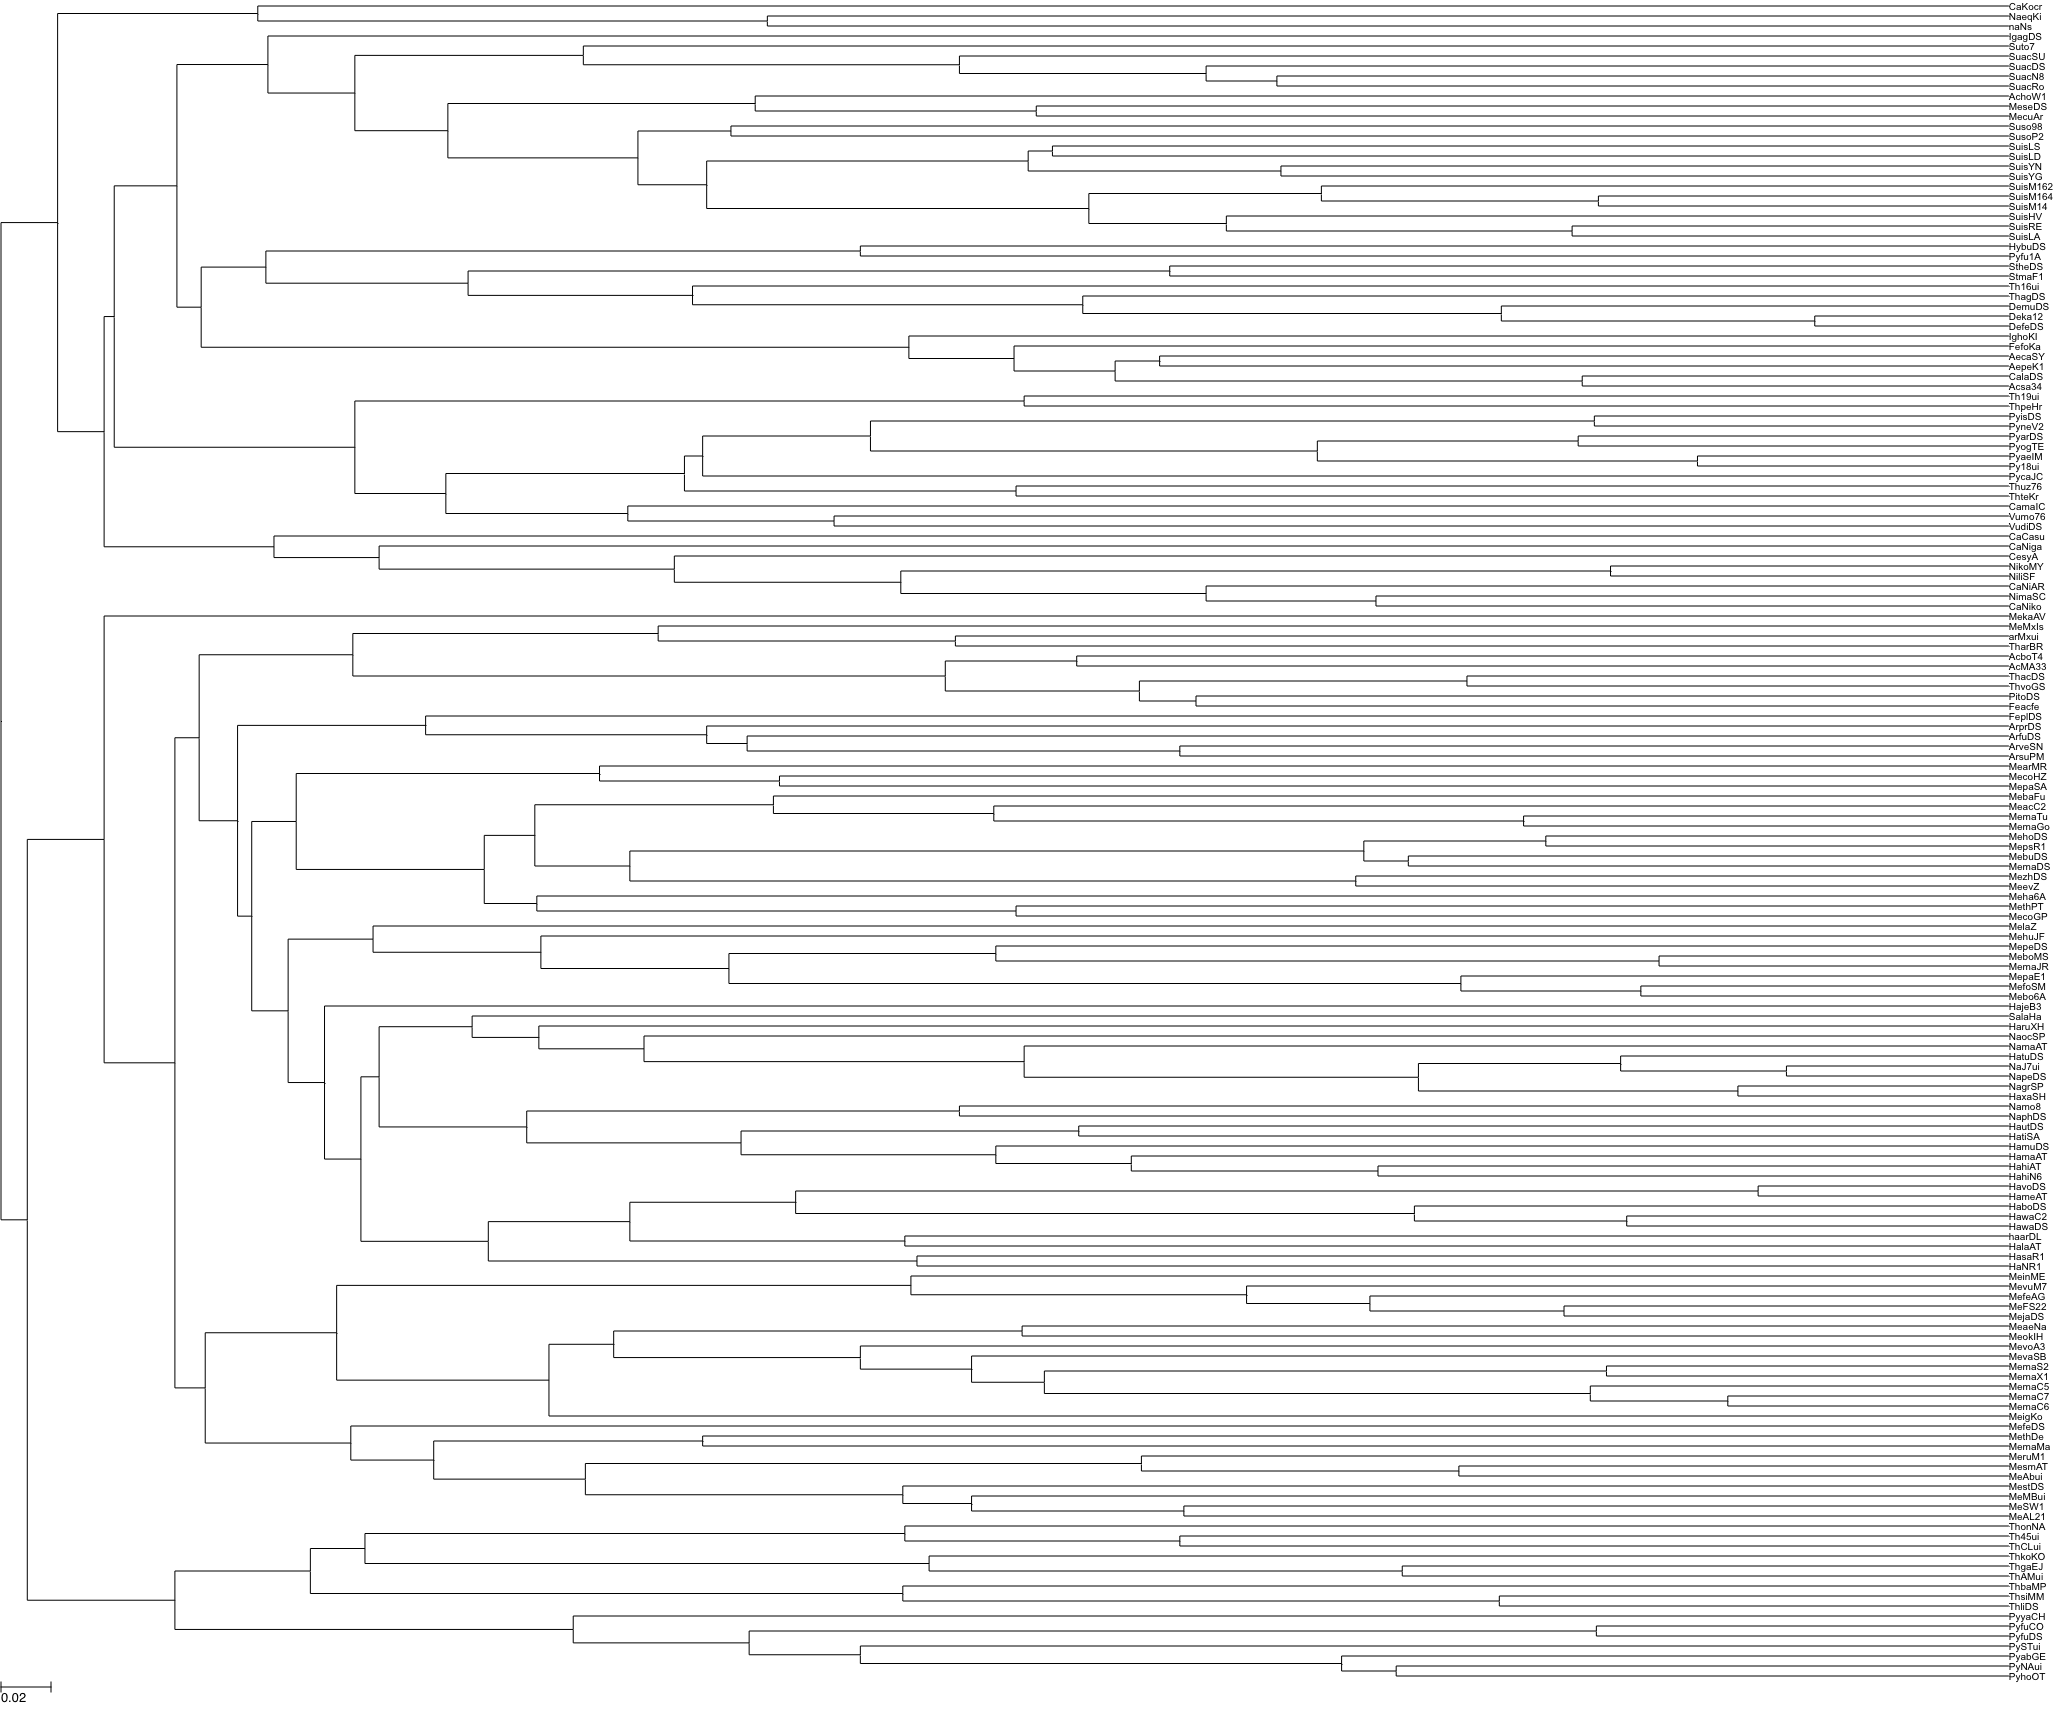

In [14]:
minScore= np.min(scores)
leastSupportedTree=allTrees[0].copy()
for i in range(len(scores)):
    if scores[i]==minScore:
        leastSupportedTree=allTrees[i].copy()
        break
ts = TreeStyle()
ts.min_leaf_separation= 0
ts.scale = 2020 
nstyle = NodeStyle()
nstyle["size"] = 0
for n in leastSupportedTree.traverse():
   n.set_style(nstyle)

leastSupportedTree.render("%%inline", tree_style=ts)  

Now, the most supported tree:

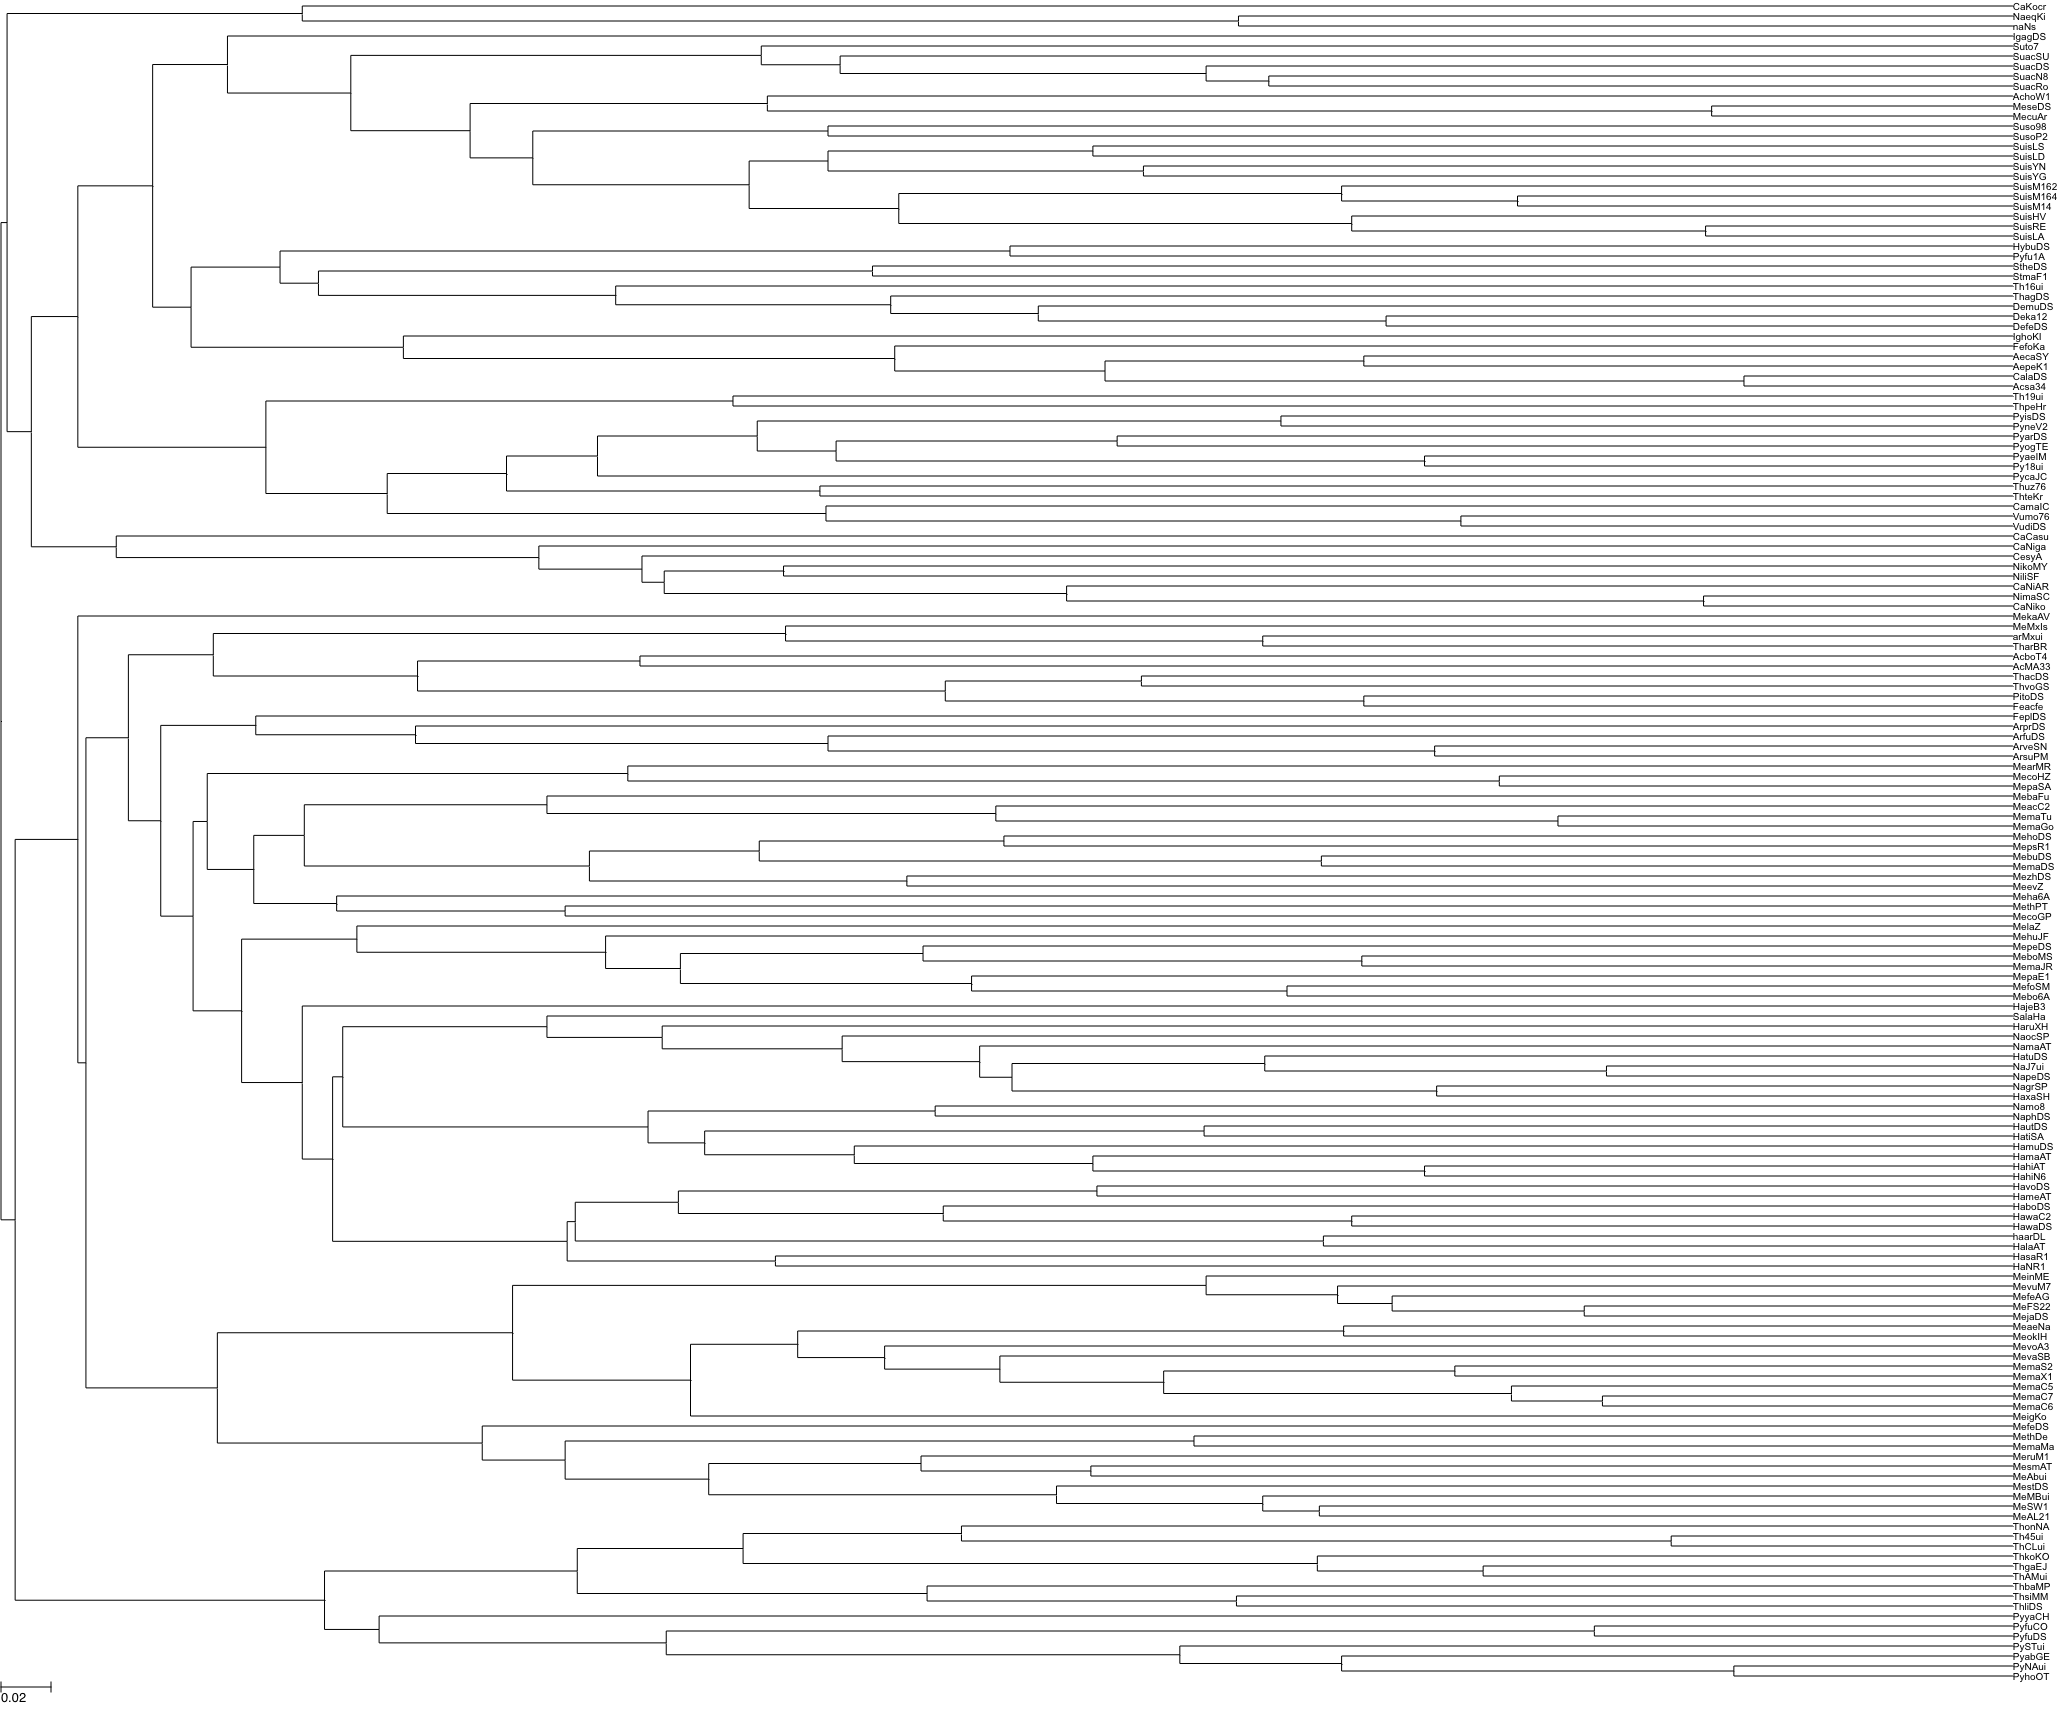

In [15]:
maxScore= np.max(scores)
mostSupportedTree=allTrees[0].copy()
for i in range(len(scores)):
    if scores[i]==maxScore:
        mostSupportedTree=allTrees[i].copy()
        break
ts = TreeStyle()
ts.min_leaf_separation= 0
ts.scale = 2020 
nstyle = NodeStyle()
nstyle["size"] = 0
for n in mostSupportedTree.traverse():
   n.set_style(nstyle)

mostSupportedTree.render("%%inline", tree_style=ts)

Let's draw the correlation between the node ages in those two trees.

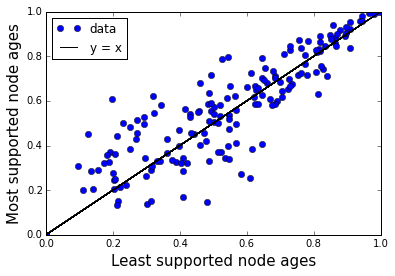

In [18]:
node2HeightLS,id2HeightLS = getNodeHeights(leastSupportedTree)
node2HeightMS,id2HeightMS = getNodeHeights(mostSupportedTree)
listLS = list(id2HeightLS.values())
listMS = list(id2HeightMS.values())
dfLS = pd.DataFrame( listLS, columns=['age'])
dfMS = pd.DataFrame( listMS, columns=['age'])
%matplotlib inline

#Plotting:
plt.plot(dfLS,dfMS, 'bo')
plt.plot( dfLS, dfLS, color="black") # add x=y
plt.xlabel('Least supported node ages', fontsize=15)
plt.ylabel('Most supported node ages', fontsize=15)
plt.legend(['data', 'y = x'], loc='upper left')


Now we compute more discriminating scores:

In [68]:
scores2 = scores - np.min(scores) 
df2 = pd.DataFrame( scores2, columns=['scores'] )
print ("Score 2: ")
print(df2.describe())
df2.to_csv("transferBasedScoresCanonicalRoot_Var500_Version2.csv")


def square (x):
    return math.pow(x,2)

def ten (x):
    return math.pow(x,10)



scores3 = list(map(ten, (scores - np.min(scores)) ) )
df3 = pd.DataFrame( scores3, columns=['scores'] )
print ("Score 3: ")
print(df3.describe())
df2.to_csv("transferBasedScoresCanonicalRoot_Var500_Version3.csv")




Score 2: 
             scores
count  10000.000000
mean     150.569000
std       37.561349
min        0.000000
25%      126.000000
50%      151.000000
75%      176.000000
max      293.000000
Score 3: 
             scores
count  1.000000e+04
mean   4.098281e+22
std    1.401578e+23
min    0.000000e+00
25%    1.008569e+21
50%    6.162678e+21
75%    2.851850e+22
max    4.663116e+24


## Comparing the three scores by computing weighted means and medians:

In [94]:
#A function to compute weighted means and medians from a dataframe
def computeWeightedMeanAndMedian(kItemdf):
    dftempSorted = kItemdf.sort_values(by='kItem', ascending=[0])
    kItem = list(dftempSorted['kItem'])
    weights = list(dftempSorted['scores']) 
    sum = 0.0
    mean = 0.0
    i = 0
    while sum <= 0.5:
        sum = sum + weights[i]
        mean += weights[i] * kItem[i]
        i = i +1
    median = kItem[i]
    for j in range(i+1, len(kItem)):
        mean += weights[j] * kItem[j]
    return mean, median

normalizedScores = list()
normalizedScores2 = list()
normalizedScores3 = list()


sumScores = 0
for s in scores:
    sumScores = sumScores + s

sumScores2 = 0
for s in scores2:
    sumScores2 = sumScores2 + s

sumScores3 = 0
for s in scores3:
    sumScores3 = sumScores3 + s

    



Edition following a commentary by Gergely: I used to normalize by the sum of all scores. Here I will try normalizing by the maximum score.

In [95]:
print(np.max(scores))
for i in range(len(scores)):
    normalizedScores.append( float(scores[i])/np.max(scores) )
    normalizedScores2.append( float(scores2[i])/np.max(scores2) )
    normalizedScores3.append( float(scores3[i])/np.max(scores3) )

scoresDF = pd.DataFrame({'kItem': scores,'scores':normalizedScores})
scores2DF = pd.DataFrame({'kItem': scores,'scores':normalizedScores2})
scores3DF = pd.DataFrame({'kItem': scores,'scores':normalizedScores3})


mea, med = computeWeightedMeanAndMedian (scoresDF)
mea2, med2 = computeWeightedMeanAndMedian (scores2DF)
mea3, med3 = computeWeightedMeanAndMedian (scores3DF)


print ("Mean and median for score 1: "+str(mea)+" ; "+str(med))
print ("Mean and median for score 2: "+str(mea2)+" ; "+str(med2))
print ("Mean and median for score 3: "+str(mea3)+" ; "+str(med3))

print("Scores 1:")
print(scoresDF.describe())
print("Scores 2:")
print(scores2DF.describe())
print("Scores 3:")
print(scores3DF.describe())



6976
Mean and median for score 1: 66935524.7745 ; 6967
Mean and median for score 2: 35158242.3823 ; 6967
Mean and median for score 3: 601215.754764 ; 6967
Scores 1:
              kItem        scores
count  10000.000000  10000.000000
mean    6833.569000      0.979583
std       37.561349      0.005384
min     6683.000000      0.957999
25%     6809.000000      0.976061
50%     6834.000000      0.979644
75%     6859.000000      0.983228
max     6976.000000      1.000000
Scores 2:
              kItem        scores
count  10000.000000  10000.000000
mean    6833.569000      0.513887
std       37.561349      0.128196
min     6683.000000      0.000000
25%     6809.000000      0.430034
50%     6834.000000      0.515358
75%     6859.000000      0.600683
max     6976.000000      1.000000
Scores 3:
              kItem        scores
count  10000.000000  10000.000000
mean    6833.569000      0.008789
std       37.561349      0.030057
min     6683.000000      0.000000
25%     6809.000000      0.000216

## Outputting the weighted trees

In [112]:
fout="transferWeightedTrees_Var500.trees"


try:
    f=open(fout, 'w')
except IOError:
    print ("Unknown file: "+fout)
    sys.exit()

i = 0
for t in allTrees:
    f.write("[&W "+str(normalizedScores[i] )+"]"+"\t"+t.write()+"\n")
    i = i+1

f.close()

In [113]:
fout="transferWeightedTrees_Var500_Version2.trees"
    
try:
    f=open(fout, 'w')
except IOError:
    print ("Unknown file: "+fout)
    sys.exit()

i = 0
for t in allTrees:
    f.write("[&W "+str(normalizedScores2[i] )+"]"+"\t"+t.write()+"\n")
    i = i+1

f.close()

In [114]:
fout="transferWeightedTrees_Var500_Version3.trees"
    
try:
    f=open(fout, 'w')
except IOError:
    print ("Unknown file: "+fout)
    sys.exit()

i = 0
for t in allTrees:
    f.write("[&W "+str(normalizedScores3[i] )+"]"+"\t"+t.write()+"\n")
    i = i+1

f.close()

## Let's compare node age distributions between the unweighted tree distribution and the weighted ones.

In [115]:
id2Heights=list()
for t in allTrees:
    node2Height,id2Height = getNodeHeights( t )
    id2Heights.append(id2Height)

In [118]:
def compute95PcCredibilityIntervalWeightedDF(kItemdf):
    dftempSorted = kItemdf.sort_values(by='kItem', ascending=[1])
    kItem = list(dftempSorted['kItem'])
    weights = list(dftempSorted['scores']) 
    sumi = 0.0
    i = 0
    while sumi <= 0.05:
        sumi = sumi + weights[i]
        i = i +1
    mini = kItem[i]
    sumi = 0.0
    i = 0
    while sumi <= 0.05:
        sumi = sumi + weights[len(kItem) - i-1]
        i = i +1
    maxi = kItem[len(kItem) - i-1]
    return mini, maxi




#Now for each node age, we compute the weighted and unweighted 95% credible interval.
unweightedIntervals = list()
weightedIntervals = list()
weightedIntervals2 = list()
weightedIntervals3 = list()

#weights1 = [1/(float)(len(normalizedScores))] * len(normalizedScores)
weights1 = [1] * len(normalizedScores)


for k,v in id2Heights[0].items():
    kItem=list()
    for j in id2Heights:
        kItem.append(j[k])
    dftemp = pd.DataFrame({ 'kItem':kItem, 'scores':normalizedScores }, dtype='float')
    dftemp2 = pd.DataFrame({ 'kItem':kItem, 'scores':normalizedScores2 }, dtype='float')
    dftemp3 = pd.DataFrame({ 'kItem':kItem, 'scores':normalizedScores3 }, dtype='float')
    dftempNoWeight = pd.DataFrame({ 'kItem':kItem, 'scores': weights1 }, dtype='float')
    min, max = compute95PcCredibilityIntervalWeightedDF(dftemp)
    weightedIntervals.append( max - min )
    min2, max2 = compute95PcCredibilityIntervalWeightedDF(dftemp2)
    weightedIntervals2.append( max2 - min2 )
    min3, max3 = compute95PcCredibilityIntervalWeightedDF(dftemp3)
    weightedIntervals3.append( max3 - min3 )
    umin, umax = compute95PcCredibilityIntervalWeightedDF(dftempNoWeight)
    unweightedIntervals.append( umax - umin )



## Credibility intervals without and with reweighting. First, the first scores:

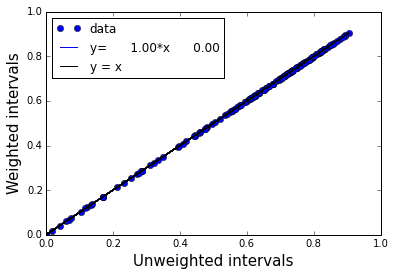

In [119]:
%matplotlib inline

def plotSingleCorrelation(unweightedIntervals,weightedIntervals,xlabel,ylabel):
    fit = np.polyfit(unweightedIntervals,weightedIntervals,1)
    fit_fn = np.poly1d(fit) 

    #Plotting the first score-reweighted trees:
    plt.plot(unweightedIntervals,weightedIntervals, 'bo')
    plt.plot(unweightedIntervals, fit_fn(unweightedIntervals), 'b-')
    plt.plot( unweightedIntervals, unweightedIntervals, color="black")
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    #plt.axis([-0.01, 0.08, -0.01, 0.06])
    regString = "y="+"{:10.2f}".format(fit[0])+"*x"+"{:10.2f}".format(fit[1])
    plt.legend(['data', regString, 'y = x'], loc='upper left')

plotSingleCorrelation(unweightedIntervals, weightedIntervals,"Unweighted intervals","Weighted intervals")

Now, the second scores:

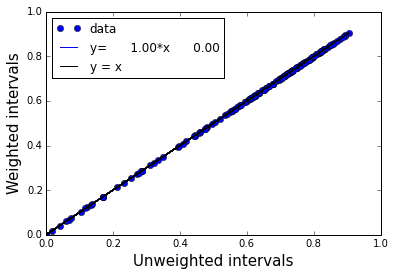

In [120]:
%matplotlib inline
plotSingleCorrelation(unweightedIntervals, weightedIntervals2,"Unweighted intervals","Weighted intervals")

Finally, the third scores:

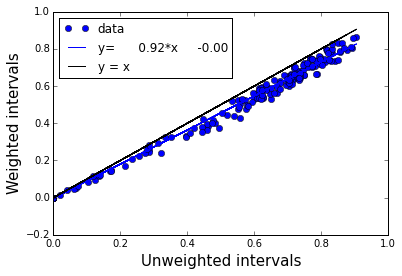

In [121]:
%matplotlib inline
plotSingleCorrelation(unweightedIntervals, weightedIntervals3,"Unweighted intervals","Weighted intervals")

## Saving weighted and unweighted chronograms

In [122]:
unweightedChrono = allTrees[0].copy()
unweightedAges = list()

for node in unweightedChrono.traverse("postorder"):
    id = 0
    if node.name != "":
        id = node.name
    else:
        id = str(node.support)
    v = list()
    for i in id2Heights:
        v.append(i[id])
    median = np.median(v)
    sd = np.std(v)
    mean = np.mean(v)
    min = np.min(v)
    max = np.max(v)
    dftempNoWeight = pd.DataFrame({ 'kItem':v, 'scores': weights1 }, dtype='float')
    ciMin = -1.0
    cMax = -1.0
    ciMin, ciMax = compute95PcCredibilityIntervalWeightedDF(dftempNoWeight)
    node.add_features(support=1.0, age_median=median, age_mean=mean, age_sd=sd, age_range="{"+str(min)+","+str(max)+"}", age_quant_5_95="{"+str(ciMin)+","+str(ciMax)+"}")
    children = node.get_children()
    for c in children:
        c.dist = node.age_median - c.age_median
    unweightedAges.append(median)
    
unweightedChrono.write(features=[], outfile="unweightedChronogram_Var500.nhx")

unweightedChronoFigTree = unweightedChrono.write(features=[]).replace("&&NHX:", "&").replace(":age", ",age").replace(":name", ",name").replace(":support", ",support").replace(":dist", ",dist").replace("_0", ",0")

fout = "unweightedChronoFigTreeFormat_Var500.tree"

try:
    f=open(fout, 'w')
except IOError:
    print ("Unknown file: "+fout)
    sys.exit()

f.write("#NEXUS\n")
f.write("BEGIN TAXA;\n")
f.write("DIMENSIONS NTAX="+str(len(unweightedChrono))+";\n")
f.write("TAXLABELS\n")
for l in unweightedChrono:
    f.write(l.name+"\n")

f.write(";\n")
f.write("END;\n")

f.write("BEGIN TREES;\n")

f.write("TREE 0 = [&R] " + unweightedChronoFigTree)

f.write("\nEND;\n")

f.close()

Now, the weighted chronogram, using the first scores.

In [123]:
weightedChrono = allTrees[0].copy()
weightedAges = list()
for node in weightedChrono.traverse("postorder"):
    id = 0
    if node.name != "":
        id = node.name
    else:
        id = str(node.support)
    v = list()
    for i in id2Heights:
        v.append(i[id])
    sd = np.std(v)
    min = np.min(v)
    max = np.max(v)
    dftempWithWeight = pd.DataFrame({ 'kItem':v, 'scores': normalizedScores }, dtype='float')
    ciMin, ciMax = compute95PcCredibilityIntervalWeightedDF(dftempWithWeight)
    mean, median = computeWeightedMeanAndMedian(dftempWithWeight)
    node.add_features(support=1.0, age_median=median, age_mean=mean, age_sd=sd, age_range="{"+str(min)+","+str(max)+"}", age_quant_5_95="{"+str(ciMin)+","+str(ciMax)+"}")
    # We also change the node age to the median value
    children = node.get_children()
    for c in children:    
        c.dist = node.age_median - c.age_median
    weightedAges.append(median)


        
weightedChrono.write(features=[], outfile="weightedChronogram_Var500.nhx")

weightedChronoFigTree = weightedChrono.write(features=[]).replace("&&NHX:", "&").replace(":age", ",age").replace(":name", ",name").replace(":support", ",support").replace(":dist", ",dist").replace("_0", ",0")

fout = "weightedChronoFigTreeFormat_Var500.tree"

try:
    f=open(fout, 'w')
except IOError:
    print ("Unknown file: "+fout)
    sys.exit()

f.write("#NEXUS\n")
f.write("BEGIN TAXA;\n")
f.write("DIMENSIONS NTAX="+str(len(weightedChrono))+";\n")
f.write("TAXLABELS\n")
for l in weightedChrono:
    f.write(l.name+"\n")

f.write(";\n")
f.write("END;\n")

f.write("BEGIN TREES;\n")

f.write("TREE 0 = [&R] " + weightedChronoFigTree)

f.write("\nEND;\n")

f.close()

Then the weighted chronogram using the second scores.

In [124]:
weightedChrono2 = allTrees[0].copy()
weightedAges2 = list()
for node in weightedChrono2.traverse("postorder"):
    id = 0
    if node.name != "":
        id = node.name
    else:
        id = str(node.support)
    v = list()
    for i in id2Heights:
        v.append(i[id])
    sd = np.std(v)
    min = np.min(v)
    max = np.max(v)
    dftempWithWeight = pd.DataFrame({ 'kItem':v, 'scores': normalizedScores2 }, dtype='float')
    ciMin, ciMax = compute95PcCredibilityIntervalWeightedDF(dftempWithWeight)
    mean, median = computeWeightedMeanAndMedian(dftempWithWeight)
    node.add_features(support=1.0, age_median=median, age_mean=mean, age_sd=sd, age_range="{"+str(min)+","+str(max)+"}", age_quant_5_95="{"+str(ciMin)+","+str(ciMax)+"}")
    # We also change the node age to the median value
    children = node.get_children()
    for c in children:
        c.dist = node.age_median - c.age_median
    weightedAges2.append(median)
weightedChrono2.write(features=[], outfile="weightedChronogram_Var500_Version2.nhx")

weightedChronoFigTree = weightedChrono2.write(features=[]).replace("&&NHX:", "&").replace(":age", ",age").replace(":name", ",name").replace(":support", ",support").replace(":dist", ",dist").replace("_0", ",0")

fout = "weightedChronoFigTreeFormat_Var500_Version2.tree"

try:
    f=open(fout, 'w')
except IOError:
    print ("Unknown file: "+fout)
    sys.exit()

f.write("#NEXUS\n")
f.write("BEGIN TAXA;\n")
f.write("DIMENSIONS NTAX="+str(len(weightedChrono2))+";\n")
f.write("TAXLABELS\n")
for l in weightedChrono2:
    f.write(l.name+"\n")

f.write(";\n")
f.write("END;\n")

f.write("BEGIN TREES;\n")

f.write("TREE 0 = [&R] " + weightedChronoFigTree)

f.write("\nEND;\n")

f.close()



Finally the weighted chronogram with the 3rd scores.

In [125]:
weightedChrono3 = allTrees[0].copy()
weightedAges3 = list()
for node in weightedChrono3.traverse("postorder"):
    id = 0
    if node.name != "":
        id = node.name
    else:
        id = str(node.support)
    v = list()
    for i in id2Heights:
        v.append(i[id])
    sd = np.std(v)
    min = np.min(v)
    max = np.max(v)
    dftempWithWeight = pd.DataFrame({ 'kItem':v, 'scores': normalizedScores3 }, dtype='float')
    ciMin, ciMax = compute95PcCredibilityIntervalWeightedDF(dftempWithWeight)
    mean, median = computeWeightedMeanAndMedian(dftempWithWeight)
    node.add_features(support=1.0, age_median=median, age_mean=mean, age_sd=sd, age_range="{"+str(min)+","+str(max)+"}", age_quant_5_95="{"+str(ciMin)+","+str(ciMax)+"}")
    # We also change the node age to the median value
    children = node.get_children()
    for c in children:
        c.dist = node.age_median - c.age_median
    weightedAges3.append(median)
weightedChrono3.write(features=[], outfile="weightedChronogram_Var500_Version3.nhx")

weightedChronoFigTree = weightedChrono3.write(features=[]).replace("&&NHX:", "&").replace(":age", ",age").replace(":name", ",name").replace(":support", ",support").replace(":dist", ",dist").replace("_0", ",0")

fout = "weightedChronoFigTreeFormat_Var500_Version3.tree"

try:
    f=open(fout, 'w')
except IOError:
    print ("Unknown file: "+fout)
    sys.exit()

f.write("#NEXUS\n")
f.write("BEGIN TAXA;\n")
f.write("DIMENSIONS NTAX="+str(len(weightedChrono3))+";\n")
f.write("TAXLABELS\n")
for l in weightedChrono3:
    f.write(l.name+"\n")

f.write(";\n")
f.write("END;\n")

f.write("BEGIN TREES;\n")

f.write("TREE 0 = [&R] " + weightedChronoFigTree)

f.write("\nEND;\n")

f.close()



Let's compare the node ages between these consensus chronograms:

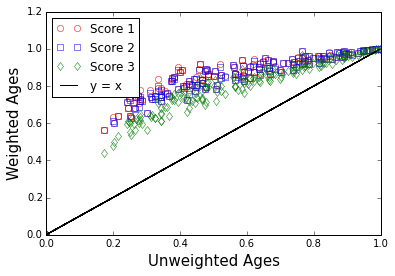

In [127]:
%matplotlib inline

#Plotting the score-reweighted node ages vs the unweighted node ages:
plt.plot(unweightedAges,weightedAges, 'ro', markerfacecolor='none', markeredgecolor="red")
plt.plot(unweightedAges,weightedAges2, 'bs', markerfacecolor='none', markeredgecolor="blue")
plt.plot(unweightedAges,weightedAges3, 'gd', markerfacecolor='none', markeredgecolor="green")

plt.plot( unweightedAges, unweightedAges, color="black") # add x=y
plt.xlabel('Unweighted Ages', fontsize=15)
plt.ylabel('Weighted Ages', fontsize=15)
plt.legend(['Score 1', 'Score 2', 'Score 3', 'y = x'], loc='upper left')



## Let's plot the differences between unweighted and weighted median branch lengths.
Although the differences are very minor, there are some differences.

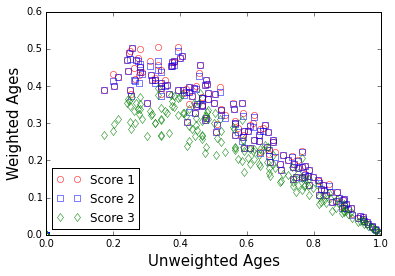

In [128]:
%matplotlib inline

def minus (a,b):
    return a-b

#Plotting the score-reweighted node ages vs the unweighted node ages:
plt.plot(unweightedAges, list(map(minus, weightedAges, unweightedAges)), 'ro', markerfacecolor='none', markeredgecolor="red")
plt.plot(unweightedAges, list(map(minus, weightedAges2, unweightedAges)), 'bs', markerfacecolor='none', markeredgecolor="blue")
plt.plot(unweightedAges, list(map(minus, weightedAges3, unweightedAges)), 'gd', markerfacecolor='none', markeredgecolor="green")


#plt.plot(unweightedAges,weightedAges2, 'bo')
#plt.plot( unweightedAges, unweightedAges, color="black") # add x=y
plt.xlabel('Unweighted Ages', fontsize=15)
plt.ylabel('Weighted Ages', fontsize=15)
plt.legend(['Score 1', 'Score 2', 'Score 3'], loc='lower left')


